In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 667626_18933d713e.jpg to 667626_18933d713e.jpg
Saving 3637013_c675de7705.jpg to 3637013_c675de7705.jpg
Saving 10815824_2997e03d76.jpg to 10815824_2997e03d76.jpg
Saving 12830823_87d2654e31.jpg to 12830823_87d2654e31.jpg
Saving 17273391_55cfc7d3d4.jpg to 17273391_55cfc7d3d4.jpg
Saving 19212715_20476497a3.jpg to 19212715_20476497a3.jpg
Saving 23445819_3a458716c1.jpg to 23445819_3a458716c1.jpg
Saving 27782020_4dab210360.jpg to 27782020_4dab210360.jpg
Saving 33108590_d685bfe51c.jpg to 33108590_d685bfe51c.jpg
Saving 35506150_cbdb630f4f.jpg to 35506150_cbdb630f4f.jpg
Saving 36422830_55c844bc2d.jpg to 36422830_55c844bc2d.jpg
Saving 41999070_838089137e.jpg to 41999070_838089137e.jpg
Saving 42637986_135a9786a6.jpg to 42637986_135a9786a6.jpg
Saving 42637987_866635edf6.jpg to 42637987_866635edf6.jpg
Saving 44129946_9eeb385d77.jpg to 44129946_9eeb385d77.jpg
Saving 44856031_0d82c2c7d1.jpg to 44856031_0d82c2c7d1.jpg
Saving 47870024_73a4481f7d.jpg to 47870024_73a4481f7d.jpg
Saving 47871819_db55

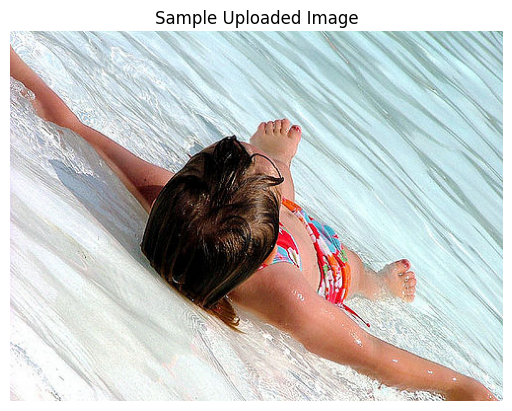

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# List of image filenames
image_files = list(uploaded.keys())

# Show one sample image
sample_image = Image.open(image_files[0])
plt.imshow(sample_image)
plt.axis('off')
plt.title("Sample Uploaded Image")
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your captions.txt file


Saving captions.txt to captions.txt


In [ ]:
import pandas as pd

# Get the file name
caption_file = list(uploaded.keys())[0]

# Read the file
df = pd.read_csv(caption_file)
df.columns = ['image', 'caption']

# Clean captions
import string

def clean_caption(caption):
    caption = caption.lower()
    caption = caption.translate(str.maketrans('', '', string.punctuation))
    return 'startseq ' + caption.strip() + ' endseq'

df['clean_caption'] = df['caption'].apply(clean_caption)

# Filter to only available images
image_files_set = set(image_files)
df = df[df['image'].isin(image_files_set)]

print("Total captions after filtering:", len(df))
df.head()


Total captions after filtering: 5015


,image,caption,clean_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,startseq a girl going into a wooden building e...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,startseq a little girl in a pink dress going i...


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = Image.open(img_path).resize((224, 224)).convert('RGB')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    feature = resnet_model.predict(img_array, verbose=0)
    return feature.flatten()

# Extract features for each image
image_features = {}
for img_name in df['image'].unique():
    image_features[img_name] = extract_features(img_name)

print("Extracted features for", len(image_features), "images.")


Extracted features for 1003 images.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_caption'])

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(c.split()) for c in df['clean_caption'])

print("Vocabulary Size:", vocab_size)
print("Max Caption Length:", max_len)


Vocabulary Size: 3189
Max Caption Length: 35


In [ ]:
def create_sequences(tokenizer, max_len, df, features):
    X1, X2, y = [], [], []
    for img_name, caption in zip(df['image'], df['clean_caption']):
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
            out_seq = tf.keras.utils.to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(features[img_name])
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

X1, X2, y = create_sequences(tokenizer, max_len, df, image_features)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

# Image feature input
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence input
inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 35, 256)   │    816,384 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35, 256)   │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 35)        │          0 │ input_layer_5[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    525,312 │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3189)      │    819,573 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,751,605 (10.50 MB)

 Trainable params: 2,751,605 (10.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit([X1, X2], y, epochs=10, verbose=1)  # Increase epochs as needed


Epoch 1/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 322s 173ms/step - loss: 4.9115
Epoch 2/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 321s 173ms/step - loss: 3.6037
Epoch 3/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 319s 171ms/step - loss: 3.2002
Epoch 4/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 321s 171ms/step - loss: 2.9353
Epoch 5/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 324s 172ms/step - loss: 2.7083
Epoch 6/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 322s 172ms/step - loss: 2.5139
Epoch 7/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 321s 171ms/step - loss: 2.3443
Epoch 8/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 317s 172ms/step - loss: 2.2106
Epoch 9/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 323s 173ms/step - loss: 2.0891
Epoch 10/10
1839/1839 ━━━━━━━━━━━━━━━━━━━━ 322s 173ms/step - loss: 1.9895


In [ ]:
def generate_caption(model, photo, tokenizer, max_len):
    in_text = 'startseq'
    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_len)
        yhat = model.predict([photo.reshape(1,2048), seq], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text.replace('startseq', '').replace('endseq', '').strip()


In [ ]:
sample_img = df['image'].iloc[0]
sample_feat = image_features[sample_img]
caption = generate_caption(model, sample_feat, tokenizer, max_len)
print(f"Generated caption for {sample_img}:\n", caption)

# Also display the image
Image.open(sample_img).show()


Generated caption for 1000268201_693b08cb0e.jpg:
 a man in a blue coat is standing in front of a large railing
